In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [54]:
#Pre-Trained model
model_path = '/content/drive/MyDrive/datasets/face_recognition/model.json'
model_weight = '/content/drive/MyDrive/datasets/face_recognition/model.h5'
json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(model_weight)

In [55]:
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


In [11]:
#model.summary()

In [12]:
FRmodel = model

In [13]:
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [44]:
database = {}
database["danielle"] = img_to_encoding("/content/drive/MyDrive/datasets/face_recognition/images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("/content/drive/MyDrive/datasets/face_recognition/images/younes.jpg", FRmodel)
database["kian"] = img_to_encoding("/content/drive/MyDrive/datasets/face_recognition/images/kian.jpg", FRmodel)
database["rahul"] = img_to_encoding("/content/drive/MyDrive/datasets/face_recognition/images/rahul.jpg", FRmodel)
database["rahulspec"] = img_to_encoding("/content/drive/MyDrive/datasets/face_recognition/images/rahul3.jpg", FRmodel)

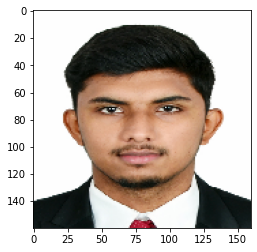

In [58]:

img = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/datasets/face_recognition/images/rahul.jpg", target_size=(160, 160))
plt.imshow(img)

In [50]:
def facerecognition(image_path, database, model):
    
    encoding =  img_to_encoding(image_path,model)
    
    min_dist = 100
    
    for (name, db_enc) in database.items():
        dist = np.linalg.norm((encoding-db_enc))
        #print(name,dist)
        if dist<min_dist:
            min_dist = dist
            identity = name
    if min_dist > 8.0:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return

In [52]:
facerecognition("/content/drive/MyDrive/datasets/face_recognition/images/rahul2.jpg", database, FRmodel)

it's rahulspec, the distance is 0.5921434


In [ ]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
  
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    return loss